<a href="https://colab.research.google.com/github/farbodtaymouri/BERT-GAN/blob/main/Coding_test_Oracle_(OOS_task).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, utils
import torch.nn as nn
from scipy.special import softmax
import torchvision
from torch.autograd import Variable
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=1000)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init  as init
import pandas as pd
import random
import pprint
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
import urllib.request, json 
import urllib, json
device=torch.device('cuda:0')
plt.style.use('ggplot')

* Installing the required libraries 

In [2]:
!pip install transformers
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import  AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

     |████████████████████████████████| 1.1MB 5.8MB/s 
     |████████████████████████████████| 1.1MB 24.2MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 
     |████████████████████████████████| 890kB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d0926405ff6035357aa0486f62166e752804557e856e603bcda02acf503caeff
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Set the seed value all over the place to make this reproducible.
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import warnings
warnings.filterwarnings('ignore')

Fri Oct 16 10:28:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |   2045MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Loading custom libraries
import sys
sys.path.append('/content/drive/My Drive/Deep Learing project')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading Json file
with urllib.request.urlopen('https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_imbalanced.json') as url:
    data = json.loads(url.read().decode())
    print(data)



In [5]:
#Converting lists to pandas dataframe (creating unique category to numeric class labels)
def list_to_df(train,test,valid):
  tot_list = train+test+valid
  df = pd.DataFrame (tot_list,columns=['content', 'label'])
  num_labels = len(df['label'].unique())
  #Creating numerical class value
  df['label_num'] = pd.factorize(df.label)[0]

  train_df = df[0:len(train)]
  test_df = df[len(train): len(train)+len(test)]
  val_df = df[len(train)+len(test): len(train)+len(test)+len(valid)]

  return train_df, test_df, val_df, num_labels 

train_df, test_df, val_df, num_labels = list_to_df(data['oos_train']+data['train'], data['oos_test']+data['test'], data['oos_val']+data['val'])


oos_train_df = train_df[0:len(data['oos_train'])]
oos_test_df = test_df[0:len(data['oos_test'])]
oos_val_df = val_df[0:len(data['oos_val'])]
test_df = test_df[len(data['oos_test']):]
val_df = val_df[len(data['oos_val']):]


print("The number of classes:", num_labels)
print("Dim of train:", train_df.shape)
print("Dim of valid:", val_df.shape)
print("Dim of test", test_df.shape)
train_df.head(100)


The number of classes: 151
Dim of train: (10625, 3)
Dim of valid: (3000, 3)
Dim of test (4500, 3)


,content,label,label_num
0,how much is an overdraft fee for bank,oos,0
1,why are exponents preformed before multiplicat...,oos,0
2,what size wipers does this car take,oos,0
3,where is the dipstick,oos,0
4,how much is 1 share of aapl,oos,0
...,...,...,...
95,what percentage of species display cold bloode...,oos,0
96,what does it mean to be an alpha male,oos,0
97,what animals have alpha males,oos,0
98,why do males want to be alpha,oos,0


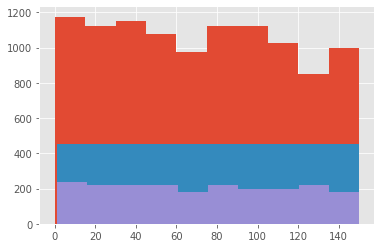

In [ ]:
#Class distributions across train.test, and validation sets
train_df['label_num'].hist()
test_df['label_num'].hist()
val_df['label_num'].hist()

In [ ]:
#Getting some insights about the sequence lengths
token_lens = []
tokens_list =[]

for txt in data['train']:
  tokens = tokenizer.encode(txt[0], truncation='only_first', max_length=50)
  token_lens.append(len(tokens))
  tokens_list.append(tokens)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


33

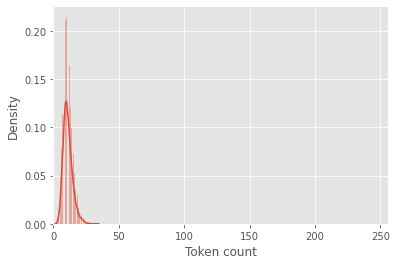

In [ ]:
data['train']
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [6]:
#Data model class class
class IntentDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews  #A request
    self.targets = targets  # An Intent
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.encoding =''

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation='only_first',
      return_tensors='pt',
    )
    return {
      #'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'token_type_ids' : encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)

    }
#-----------------------------------------------
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IntentDataset(
    reviews=df.content.to_numpy(),
    targets=df.label_num.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  #Returning a Pytorch tensor
  return DataLoader(
    ds,
    batch_size=batch_size,
    sampler = RandomSampler(ds), # Select batches randomly
    num_workers=1
  )

In [8]:
BATCH_SIZE = 16
MAX_LEN = 150
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

oos_test_loader = create_data_loader(oos_test_df, tokenizer, MAX_LEN, BATCH_SIZE)
oos_val_loader = create_data_loader(oos_val_df, tokenizer, MAX_LEN, BATCH_SIZE)

for uu in iter(train_loader):
  print(uu)
  break

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([[  101,  2054,  2015,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1045,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  3531, 17542,  ...,     0,     0,     0],
        [  101,  2061,  2054,  ...,     0,     0,     0],
        [  101,  1045,  2079,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'targets': tensor([127,  14, 149, 124,  46,  20,  86,  60,  25, 141, 119,  46, 109,  34,
         16, 144])}


In [ ]:
#Creating the model using the pretrained BERT model
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        #Bert for classification. The number of labels adds a fully connected layer on top of BERT
        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased",return_dict=True, num_labels=num_labels)

    def forward(self, inputs, labels ):

        outputs = self.encoder(inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'], labels=labels)

        return outputs


bert_model = BERT().to(device)

In [ ]:
#Creating a weight vector for Intent labels. 0 shows out of scope label
#For normal training all the weights are the same. However, for the imbalance case, we assign a larger weight to the out-of-scope label
label_weights=[]
for label in train_df['label_num'].unique():
  if(label ==0):
    label_weights.append(1)
  else:
    label_weights.append(1)  

label_weights = torch.tensor(label_weights).float()

In [ ]:
EPOCHS = 10
optimizer = AdamW(bert_model.parameters(), lr=2e-5, eps = 1e-8, correct_bias=False)
#The number of steps is the number of batched file * epoch
total_steps = len(train_loader) * EPOCHS

#Hyperparameter tunning
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#Cross-entripy function for the classification
loss_fn = nn.CrossEntropyLoss( weight= label_weights).cuda()

In [ ]:
def train(model, EPOCHS, label_weights):
  inp={}
  # training loop
  model.train()

  train_loss=[]
  val_loss=[]
  val_acc=[]
  recall_scores=[]
  for i in tqdm(range(EPOCHS)):
      losses = []
      correct_predictions = 0    #Number of correct predcitions
      total_predictions=0        #Total number of predictions
      for mini_batch in iter(train_loader):
        inp['input_ids'] = mini_batch['input_ids'].cuda()
        inp['token_type_ids'] = mini_batch['token_type_ids'].cuda()
        inp['attention_mask'] = mini_batch['attention_mask'].cuda()
        intent_labels = mini_batch['targets'].cuda()
        

        #Forward Propagation
        optimizer.zero_grad()
        outputs = model(inp, labels= intent_labels)
        #print(outputs.logits.size())


        #Predicting the class lables
        preds = torch.argmax(outputs.logits, dim=1)
        #print('pred:',preds)

        #Computing the loss function
        loss = loss_fn(outputs.logits, intent_labels)

        correct_predictions += torch.sum(preds == intent_labels)
        total_predictions +=  len(intent_labels)
        losses.append(loss.item())


        #Backward propagation
        loss.backward()
        #clipping the gradient norm to avoid gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #Update the weights
        optimizer.step()
        #Update the learning rates
        scheduler.step()
        #break
      print("\n The loss value on training:", np.mean(losses))
      print("correct predictions and total predictions:", correct_predictions, total_predictions )
      #print("Prediction accuracy on training:", correct_predictions.double() / total_predictions )

      if(i%2==0):
        #Evaluating the model
        loss, acc = model_eval(bert_model, val_loader, 'In-Scope')
        rec_score = model_eval(bert_model, oos_val_loader, 'Out-Of-Scope')
        val_loss.append(loss); val_acc.append(acc); train_loss.append(np.mean(losses)); recall_scores.append(rec_score)
        model.train()

  return  val_loss, val_acc, train_loss, recall_scores
        #break

val_loss, val_acc, train_loss, val_recall = train(bert_model, EPOCHS, label_weights) 





[4.151581699000303, 1.4230137733702963, 0.48379974221204913, 0.20175019551442205, 0.09401118366110017, 0.05222381871635247, 0.0339949026174481, 0.02375912684437714, 0.019008337320493802, 0.016568788866537953]


<Figure size 432x288 with 0 Axes>

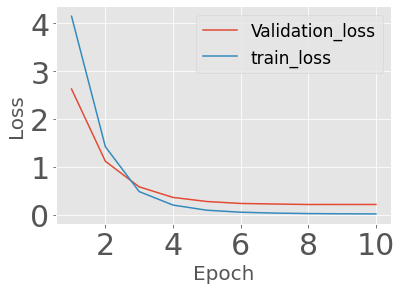

<Figure size 432x288 with 0 Axes>

In [ ]:
print(train_loss)
plt.plot(range(1, EPOCHS+1), val_loss, label = 'Validation_loss')
plt.plot(range(1, EPOCHS+1), train_loss, label = 'train_loss')


plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(prop={'size': 17})
#plt.title('BPI17',fontdict = {'fontsize' : 20})
plt.figure()

[4.151581699000303, 1.4230137733702963, 0.48379974221204913, 0.20175019551442205, 0.09401118366110017, 0.05222381871635247, 0.0339949026174481, 0.02375912684437714, 0.019008337320493802, 0.016568788866537953]


<Figure size 432x288 with 0 Axes>

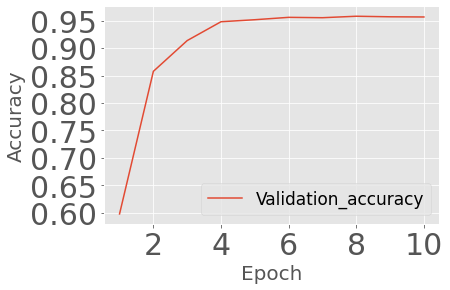

<Figure size 432x288 with 0 Axes>

In [ ]:
print(train_loss)
plt.plot(range(1, EPOCHS+1), val_acc, label = 'Validation_accuracy')

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(prop={'size': 17})
plt.figure()

In [ ]:
def model_eval(model, data_loader, mode):
  '''
  A method for model evaluation.
  '''
  inp={}
  
  #Turning on the evaluation mode
  model.eval()

  losses = []
  correct_predictions = 0    #Number of correct predcitions
  total_predictions=0        #Total number of predictions
  recall_scores=[]
  for mini_batch in iter(data_loader):
    inp['input_ids'] = mini_batch['input_ids'].cuda()
    inp['token_type_ids'] = mini_batch['token_type_ids'].cuda()
    inp['attention_mask'] = mini_batch['attention_mask'].cuda()
    intent_labels = mini_batch['targets'].cuda()
    

    #Forward Propagation
    outputs = model(inp, labels= intent_labels)
    #print(outputs.logits.size())


    #Predicting the class lables
    preds = torch.argmax(outputs.logits, dim=1)


    if(mode == 'In-Scope'):
      #Computing the loss function
      loss = loss_fn(outputs.logits, intent_labels)
      correct_predictions += torch.sum(preds == intent_labels)
      total_predictions +=  len(intent_labels)
      losses.append(loss.item())

    elif(mode =='Out-Of-Scope'):
      preds[preds>0]=1
    
      OOS_recall = recall_score(preds.tolist(), intent_labels.tolist(), average='binary')
      recall_scores.append(OOS_recall)


  if(mode == 'In-Scope'):
    print("\n The loss value on evaluation:", np.mean(losses))
    print("correct predictions and total predictions on validation:", correct_predictions, total_predictions )
    print("Prediction accuracy on evaluation:", correct_predictions.double() / total_predictions )
    return np.mean(losses), correct_predictions.double() / total_predictions

  elif(mode =='Out-Of-Scope'):
    print("\n The recall for Out-Of-Scope Intents:", np.mean(recall_scores))
    return np.mean(recall_scores)

  


#model_eval(bert_model, test_loader, 'In-Scope')
model_eval(bert_model, oos_test_loader, 'Out-Of-Scope')

      #break

In [ ]:
torch.save(bert_model.state_dict(),'/content/drive/My Drive/Deep Learing project/bert_model(validation).m')